# boostcourse_tensorflow2.0_cnn_project

### 실습 전 안내
* 실습코드는 <font color='red'>Python 3.6</font>, <font color='red'>TensorFlow 2.0</font>버전을 기준으로 작성되었습니다. 원활한 실습 진행을 위해 버전을 맞춰주시는 것을 권장드립니다.
* 간혹 컴퓨터 성능에 따라 모델을 학습시키는 과정에서 시간이 소요될 수 있습니다. 이 경우 <font color='red'>Colab</font>으로 실습을 진행해주시는 것을 권장드립니다.

## Colab 사용자를 위한 안내

해당 노트북은 **로컬** 환경에서 최적화 되어 있습니다. **로컬 환경에서 진행하시는 분**들은 바로 학습을 진행하시면 됩니다.

**Colab을 사용하시는 분**들은 처음에 아래 주석을 해제하시고 한번 만 실행시켜주세요!

* 주석을 해제하는 방법: 해당 영역을 선택하고, `Ctrl + /` 를 누르면 해당 영역의 주석에 해제됩니다.

In [3]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


Colab 을 사용하시는 분들은 아래 주석을 해제하시고 `folder` 변수 명에 프로젝트 디렉토리를 저장한 위치를 작성해주세요! 예를 들어, `02_cnn_tf` 의 위치가 "내 드라이브 > colab_notebook > tensorflow" 폴더 안에 있는 경우, "colab_notebook/tensorflow" 를 작성하시면 됩니다.

```python
folder = "colab_notebook/tensorflow"
```

In [4]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = ""
project_dir = "02_cnn_tf"

base_path = Path("/content/drive/My Drive/Colab Notebooks")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/Colab Notebooks/02_cnn_tf


# Convolutional Neural Network: Cat-Dog Classifier

<img src="https://drive.google.com/uc?id=16c7SWB6wboraKe4OFRmSU6RywZhWB9Xc" width="600px" height="400px" />

* 이미지 출처: ImageNet Classification with Deep Convolutional Neural Networks(A Krizhevsky, 2012)

ImageNet classifcation challenge는 컴퓨터를 통해 총 1000가지 종류의 사물에 대한 이미지를 분류하는 대회입니다. 이 대회에서 모델 학습을 위해 제공하는 학습 이미지는 100만장이 훌쩍 넘습니다. 지난 수 년간 대회가 진행되었는데, 초창기에는 이 시각 인지(visual recognition) 문제를 인간만큼 잘 처리하는 알고리즘이 나오지 못했습니다. 하지만 2012년 CNN의 등장과 함께 엄청난 성능 향상이 시작되었습니다.

<img src="https://drive.google.com/uc?id=1twuxI3IlZbgF2glLKyGoD6yGh5LQZLys" width="800px" height="400px" /><caption><center>&lt;2012년 AlexNet이 등장하면서 CNN은 많은 주목을 받기 시작합니다&gt;</center></caption>

* 이미지 출처: [링크](https://www.researchgate.net/figure/Winner-results-of-the-ImageNet-large-scale-visual-recognition-challenge-LSVRC-of-the_fig7_324476862)

2011년에 우승한 알고리즘의 오차율(error rate)이 26% 였는데, 2012년 CNN기반의 AlexNet이 1년만에 무려 10%의 오차율을 줄이면서 우승하게 되었습니다. 2015년에는 마찬가지로 CNN기반의 ResNet이 등장하면서 3.6%의 오차율을 기록했는데, 이는 실제 사람의 평균 오차율인 5%를 넘는 기록입니다. 이제 우리는 컴퓨터 알고리즘을 통해 사람보다 사물을 정확하게 인식할 수 있는 것입니다. 그리고 이러한 변화는 CNN의 등장과 함께 매우 짧은 시간에 이루어진 것이었습니다. 실제로 최근 딥러닝의 인기는 CNN의 등장 그리고 컴퓨터 비전(computer vision)분야의 엄청난 발전과 깊은 관련이 있다고 할 수 있습니다. 이번 프로젝트에서는 CNN을 직접 설계하여 고양이와 강아지를 분류하는 문제를 해결해 볼 것입니다. 여기에 약간의 제약 조건을 추가해, 상당히 적은 양의 데이터를 가지고도 매우 빠른 시간안에 높은 성능의 모델을 학습시키는 방법에 대해 배울 것입니다.

이번 실습의 목표는 다음과 같습니다.
- CNN을 설계하고 이미지 분류기를 학습시킨다.
- 학습 과정에서 데이터 증식(data augmentation)을 적용한다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 전이학습(transfer learning)을 구현할 수 있다.

이번 과정을 통해 얻는 최종 결과물은 아래 그림과 같습니다.

<img src="https://drive.google.com/uc?id=12IySBKqWiWdBR-IjkKWW41czlAjEqm5U" width="800px" height="300px" /><caption><center>&lt;CNN을 통해 강아지와 고양이분류를 구현합니다&gt;</center></caption>

**"[TODO] 코드 구현"** 부분의 **"# 코드 시작"** 부터 **"# 코드 종료"** 구간에 필요한 코드를 작성해주세요. **나머지 작성구간이 명시 되지 않은 구간은 임의로 수정하지 마세요!**

**본문 중간중간에 TensorFlow 함수들에 대해 [TensorFlow API 문서](https://www.tensorflow.org/api_docs/python/tf) 링크를 걸어두었습니다. API 문서를 직접 확인하는 일에 익숙해지면 나중에 여러분이 처음부터 모델을 직접 구현해야 할 때 정말 큰 도움이 됩니다.**을 적용한다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 전이학습(transfer learning)을 구현할 수 있다.

<h1>목차<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Colab-사용자를-위한-안내" data-toc-modified-id="Colab-사용자를-위한-안내-1">Colab 사용자를 위한 안내</a></span></li><li><span><a href="#Convolutional-Neural-Network:-Cat-Dog-Classifier" data-toc-modified-id="Convolutional-Neural-Network:-Cat-Dog-Classifier-2">Convolutional Neural Network: Cat-Dog Classifier</a></span><ul class="toc-item"><li><span><a href="#1.-Package-load" data-toc-modified-id="1.-Package-load-2.1">1. Package load</a></span></li><li><span><a href="#2.-데이터셋-다운로드-및-훈련,-검증,-테스트-데이터셋-구분" data-toc-modified-id="2.-데이터셋-다운로드-및-훈련,-검증,-테스트-데이터셋-구분-2.2">2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구분</a></span></li><li><span><a href="#3.-하이퍼파라미터-세팅" data-toc-modified-id="3.-하이퍼파라미터-세팅-2.3">3. 하이퍼파라미터 세팅</a></span></li><li><span><a href="#4.-tf.data.Dataset을-이용하여-Input-pipeline-만들기" data-toc-modified-id="4.-tf.data.Dataset을-이용하여-Input-pipeline-만들기-2.4">4. <code>tf.data.Dataset</code>을 이용하여 Input pipeline 만들기</a></span></li><li><span><a href="#5.-네트워크-설계" data-toc-modified-id="5.-네트워크-설계-2.5">5. 네트워크 설계</a></span></li><li><span><a href="#6.-Loss-function-및-Optimizer-정의" data-toc-modified-id="6.-Loss-function-및-Optimizer-정의-2.6">6. Loss function 및 Optimizer 정의</a></span></li><li><span><a href="#7.-Training" data-toc-modified-id="7.-Training-2.7">7. Training</a></span></li><li><span><a href="#8.-저장된-모델-불러오기-및-Evaluation" data-toc-modified-id="8.-저장된-모델-불러오기-및-Evaluation-2.8">8. 저장된 모델 불러오기 및 Evaluation</a></span></li><li><span><a href="#9.-Transfer-Learning" data-toc-modified-id="9.-Transfer-Learning-2.10">9. Transfer Learning</a></span></li><li><span><a href="#10.-Summary" data-toc-modified-id="10.-Summary-2.11">10. Summary</a></span></li></ul></li><li><span><a href="#Self-Review" data-toc-modified-id="Self-Review-3">Self-Review</a></span></li></ul></div>

## 1. Package load

필요한 패키지들을 로드합니다.

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import check_util.checker as checker
from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tensorflow version: 2.9.2
GPU 사용 가능 여부: True


## 2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구분

이번 실습에서는 고양이와 강아지 이미지를 분류하는 네트워크를 학습시킬 것입니다.
우리가 이번에 사용할 데이터셋은 2013년 후반에 '캐글'이라는 데이터사이언스 대회 플랫폼에서 열린 컴퓨터 비전 경연 대회의 일환으로 제작되었습니다. 참고로 CNN을 사용한 참가자가 95% 정확도를 달성하여 당시 대회 우승을 차지했습니다.

이번 예제에서 사용할 강아지-고양이 이미지 데이터셋 원본 출처는 [이곳](https://www.kaggle.com/c/dogs-vs-cats/data)입니다. 데이터셋은 편의상 미리 다운로드 받아 압축해 제공해드렸습니다. 

아래 주석을 해제하시고 실행하면 로컬에서 압축을 풀지 않고, 압축을 해제할 수 있습니다. **(로컬, Colab 동일)**



In [6]:
import zipfile
from pathlib import Path

current_path = Path().absolute()
data_path = current_path / "data"
print("현재 디렉토리 위치: {}".format(current_path))
if (data_path / "my_cat_dog").exists():
    print("이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!")
else:
    with zipfile.ZipFile(str(data_path / "my_cat_dog.zip"), "r") as zip_ref:
        zip_ref.extractall(str(data_path / "my_cat_dog"))
    print("Done!")

현재 디렉토리 위치: /content/drive/MyDrive/Colab Notebooks/02_cnn_tf
이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!


원본 데이터셋에는 고양이와 강아지 이미지가 각각 12500개로 총 25000개의 학습용 데이터셋이 구성되어 있습니다.
이 정도면 강아지와 고양이를 학습시키에는 어느정도 충분한 양입니다. 이번 실습에서 우리는 훨씬 더 적은 양의 데이터만 사용해 볼 것입니다. 이처럼 비교적 매우 적은 양의 데이터만 가지고도 많은 양의 데이터를 통해 학습시킨 모델에 크게 뒤지지 않는 모델을 학습시키는 방법에 대해서 배워볼 것입니다.

제공해드린 데이터셋에는, 훈련용 데이터가 class당 1000개, 검증용 데이터가 class당 500개, 마지막으로 테스트용 데이터는 class당 1000개로 구성되어 있습니다.

In [7]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

아래의 코드를 실행하면 데이터셋 구성이 올바르게 되었는지 확인할 수 있습니다. 

다음과 같은 결과가 나온다면 데이터셋 구성이 정상적으로 이루어진 것입니다.

만약 아래와 같은 결과가 나오지 않는다면 `./data/my_cat_dog.zip`을 같은 경로인 'data' 폴더에 수동으로 압축 해제하시기 바랍니다.

```
훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 강아지 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 강아지 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000
```

In [8]:
checker.dataset_check(data_dir)

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000
dataset이 제대로 구성되어 있습니다! 이어서 진행하셔도 좋습니다.


## 3. 하이퍼파라미터 세팅

학습에 필요한 하이퍼파라미터의 값을 초기화해줍니다. 하이퍼파라미터는 뉴럴네트워크를 통하여 학습되는 것이 아니라 학습율(learning rate), 사용할 레이어의 수 등 설계자가 결정해줘야 하는 값들을 의미합니다.

미니배치의 크기(`batch_size`), 학습 할 epoch 수(`max_epochs`), 학습률(`learning_rate`) 등의 값들을 다음과 같이 정했습니다.

In [9]:
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 20
learning_rate = 1e-4
IMG_SIZE = 150

PATH = data_dir

## 4. `tf.data.Dataset`을 이용하여 Input pipeline 만들기
 
* `tf.data.Dataset`에 대한 자세한 설명은 [Importing Data](https://www.tensorflow.org/guide/datasets) 페이지 참조
* 이전 실습에서는 `tf.keras.datasets`에 이미 정의되어 있는 FashionMNIST dataset을 불러와서 사용하였습니다.
* 이번 실습에서는 `tf.data.Dataset`를 이용하여 폴더 안에 있는 파일 리스트를 읽고 augmentation 하는 과정을 만들어보겠습니다.
  * `tf.data.Dataset.list_files`을 이용하여 폴더 안에 파일 리스트를 가지고 `tf.data.Dataset`을 만들어봅니다.
  * `tf.data.Dataset.map` 함수를 이용하여 data augmentation을 적용해봅니다.

### 데이터 증식(Data Augmentation) 함수

우리는 이번 실습에서 모델을 학습시키는 데에 비교적 적은 양의 데이터셋을 사용하고 있습니다. 이처럼 적은 양의 훈련 데이터를 통해 학습시킨 모델은 오버피팅의 문제가 매우 심각할 수 있습니다. 데이터 증식(data augmentation) 기법은 이러한 작은 데이터셋의 한계를 어느정도 극복하기 위한 좋은 방법입니다. 데이터 증식은 학습할 때 기존의 데이터에 약간의 변형을 가해 모델에 넣어주는 기법을 말합니다. 이렇게 함으로써 모델은 실질적으로 매 epoch마다 서로 다른 데이터를 학습하게 됩니다. 실제로 데이터를 늘리는 것은 아니지만 모델 입장에서는 같은 데이터가 매번 다른 변형을 통해 들어가기 때문에 다양한 이미지처럼 느끼고 다양한 패턴을 고려하여 학습하게 됩니다.

데이터 증식을 통한 학습과정을 도식화하면 다음과 같습니다. 

<img src="https://drive.google.com/uc?id=1b0o9nVH8sDQyv_jSvRjjm5WT0jQ6XYxH" width="600px" height="400px" />
<caption><center>&lt;데이터 증식을 통한 학습과정 도식화&gt;</center></caption>

데이터 증식 기법에는 여러가지가 있습니다. 우리는 모델 훈련과정에서 다양한 증식 기법을 랜덤하게 적용하여 훈련용 데이터를 증식하는 효과를 얻을 것입니다.

이번 실습에서 적용할 데이터 증식(data augmentation) 기법은 다음과 같습니다. 
* `random_crop`: 우리가 가진 원본 데이터는 이미지마다 크기가 다르기 때문에 모델에 입력으로 주기 위해서는 반드시 일정한 크기로 맞추어 줘야 합니다. 우리 모델에서는 150 $\times$ 150로 입력 이미지의 크기를 고정하겠습니다.
* `random_rotation`: 이미지를 random 한 각도(-0.3radian ~ 0.3radian)로 회전을 시킵니다.
* `flip_left_right`: 1/2의 확률로 이미지를 좌우 반전시킵니다.

검증 또는 테스트를 진행하는 경우에는, 실행할 때마다 일관된 결과가 나오도록 하기 위해 데이터 증식 기법을 적용하지 않습니다. 하지만 `resize`를 통해 마찬가지로 150 $\times$ 150으로 이미지 크기를 고정해주도록 합니다. 

각각의 기법을 적용한 예시는 다음과 같습니다.

<img src="https://drive.google.com/uc?id=1wvJplIH2Ky04-75m8I6g5lmCO6fcx16I" width="800px" height="200px" />

### <font color='red'>[TODO] 코드 구현</font>

Augmentation 관련 코드들은 직접 구현해봅니다. TensorFlow 안에 다양한 image 처리 API는 [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image)를 참고 하시면 됩니다. 본 실습에서 사용하는 방법이 아닌 자동으로 이미지 데이터를 증식 시키는 API인 [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)가 있지만 이 실습에서는 여러분만의 데이터 증식 기법을 만들어 보게 될겁니다.

#### load 함수 구현

* `tf.io.read_file(filename)` 함수를 이용하여 `filename`에 해당하는 파일을 읽습니다.
    * `filename`은 `string`으로 된 파일 경로 입니다.
* `tf.io.read_file()` 함수를 통해 읽으면 바이너리 형태로 읽고 그것을 `tf.image.decode_jpeg()` 함수를 통해 decode 하여 `tf.uint8` 타입의 이미지 데이터로 변환합니다.
* 그 후 `tf.cast`를 통해 `tf.uint8`타입을 `tf.float32`타입으로 바꾸어 주어야 합니다.

In [10]:
def load(image_file, label):
    # 해당경로의 파일을 읽어서 float 타입으로 변환합니다.
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image, label

아래의 코드블록은 구현된 이미지 로드 함수를 테스트 합니다.

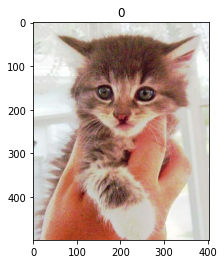

In [11]:
image, label = load(os.path.join(PATH, 'train/cat/cat.100.jpg'), 0)
# casting to int for matplotlib to show the image
plt.figure()
plt.title(label)
plt.imshow(image/255.0)
plt.show()

#### `resize`함수를 구현

* 이미지를 원하는 사이즈 (높이 `height`와 너비 `width`)로 변환하는 작업을 합니다.
* argument로 `image`와 resize하고자 하는 `height`, `width`를 받아서 resize를 합니다.
* [`tf.image.resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize) 사용합니다.

**resize 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [12]:
def resize(input_image, height, width):
    # 원하는 height와 width로 이미지를 resize 합니다.

    ## 코드 시작 ##
    input_image = tf.image.resize(input_image,[height,width])
    ## 코드 종료 ##

    return input_image

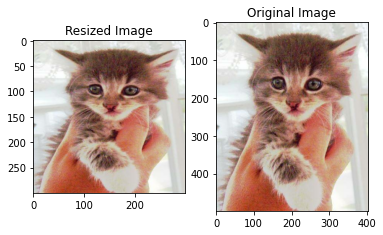

In [13]:
plt.figure()
plt.subplot(121)
plt.title("Resized Image")
plt.imshow(resize(image, 300, 300)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [14]:
checker.resize_fn_check(resize)

resize 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


#### `random_rotation`함수를 구현

* 이미지를 임의의(random) 각도로 회전하는 작업을 합니다.
* Random 하게 회전할 각도를 `angle`이라는 변수로 두고 `np.random.randint`을 통해서 0~3 사이의 값을 뽑아냅니다.
    * [`tf.image.rot90`](https://www.tensorflow.org/api_docs/python/tf/image/rot90) 사용하여 입력이미지와 회전하려는 각도를 전달해주면 됩니다.

**random_rotation 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [33]:
def random_rotation(input_image):
    # 이미지를 원하는 각도(radian)로 회전 시킵니다.

    ## 코드 시작 ##
    angles = np.random.randint(0,3)
    rotated_image = tf.image.rot90(input_image,angles)
    ## 코드 종료 ##  

    return rotated_image

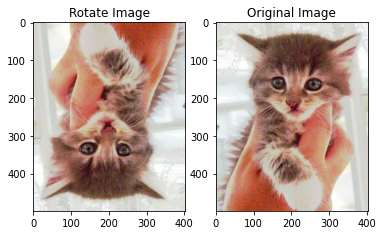

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Rotate Image")
plt.imshow(random_rotation(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

#### `random_crop`함수를 구현

* 이미지를 원하는 size로 crop (영역 추출) 합니다.
    * 특정영역에서 crop하지 않고 random 하게 하기 때문에 `random_crop`입니다.
    * 차후 `central_crop` 구현도 있으니 주의하세요.
* [`tf.image.random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/random_crop) 사용
    * `tf.image.random_crop(image, size)` 함수의 인자(argument)로는 이미지와 crop할 size(높이, 너비, 채널)를 알려주면 됩니다.
  
**random_crop 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [16]:
def random_crop(input_image):

    ## 코드 시작 ##
    cropped_image = tf.image.random_crop(input_image,size=[150,150,3])
    ## 코드 종료 ##

    return cropped_image

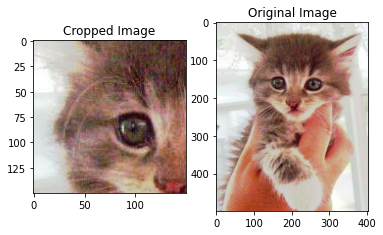

In [17]:
plt.figure()
plt.subplot(121)
plt.title("Cropped Image")
plt.imshow(random_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [18]:
checker.random_crop_fn_check(random_crop)

random_crop 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


#### `normalize`함수를 구현

* 이미지는 [0, 255]사이의 픽셀 값으로 이루어져 있습니다.
* [0, 255] 범위에 있는 픽셀 값을 [-1, 1]로 만드는 것을 normalize 라고 합니다.
* 아래 방법을 이용하여 `normalize`함수를 만들어 보세요. 아래의 절차를 한줄로 구현하시면 됩니다(TensorFlow 함수를 이용하지 않고 일반적인 나눗셈과 뺌셈 연산을 수행하면 됩니다).
    * 이미지 픽셀값을 127.5로 나눈다: [0, 255] -> [0, 2]
    * 다시 1을 빼준다: [0, 2] -> [-1, 1]
  
**normalize 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [19]:
# normalizing the images to [-1, 1]
def normalize(input_image):
    # 이미지 픽셀값의 범위를 normalize 합니다. [0, 255] -> [-1, 1]

    # 코드 시작
    input_image = input_image //127.5
    # 코드 종료

    return input_image

In [20]:
checker.normalize_fn_check(normalize)

normalize 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


#### `random_jitter`함수를 구현

* `random_jitter`함수는 학습 시 이미지 증식(augment)를 수행하기 위하여 위에서 직접 구현한 `resize`, `random_rotation`, `random_crop`들을 이용합니다.
* `random_jitter` 구현 할때 추가로 random 이미지 좌우반전도 적용해봅니다.
    * [`tf.image.random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)을 사용
  
* 전체 구현 pipeline
    1. `resize`: 176 x 176 size로 resize
    2. `random_crop`: 150 x 150 size로 random crop
    3. `random_rotation`: 임의의 각도로 (위에 random_rotation 함수에서 정한) 이미지 회전
    4. `random_flip_left_right`: 반반의 확률로 좌우 반전
  
**random_jitter 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [66]:
def random_jitter(input_image):
    # resize, random_crop, random_rotation, random_flip 함수들을 이용하여 augmentation을 합니다.

    ## 코드 시작 ##
    # resizing to 176 x 176 x 3
    input_image = tf.image.resize(input_image,[176,176])
    # randomly cropping to 150 x 150 x 3
    input_image = tf.image.random_crop(input_image,size=[150,150,3])
    # randomly rotation
    input_image = tf.image.rot90(input_image) 
    # randomly mirroring
    input_image = tf.image.random_flip_left_right(input_image)
    ## 코드 종료 ##

    return input_image

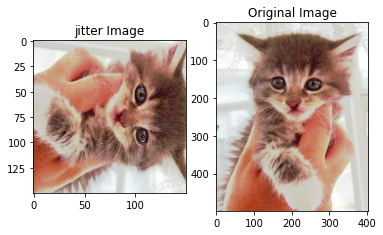

In [67]:
plt.figure()
plt.subplot(121)
plt.title("jitter Image")
plt.imshow(random_jitter(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

#### `central_crop` 함수를 구현

* 학습 할 때는 이미지 증식을 위해 `random_jitter`함수를 이용합니다.
* 하지만 검증(validation) 데이터나 테스트 데이터를 랜덤하게 잘라 사용한다면 매번 다른 결과를 보일 것이고 분류기 검증을 어렵게 할 것 입니다.
* 따라서 테스트를 할때는 이미지 증식을 적용하지 않고 학습에 사용한 이미지 크기만큼 가운데를 잘라서 사용하겠습니다. 이를위해 함수 `central_crop`을 구현 하겠습니다.
    * [`tf.image.central_crop`](https://www.tensorflow.org/api_docs/python/tf/image/central_crop) 사용
    * `central_crop`의 옵션으로 전체 이미지에서 얼마의 비율로 중앙 잘라내기(crop)를 수행할지 정하는 `central_fraction` 인자가 있습니다.
    * (176 x 176)으로 resize한 후 `central_fraction`을 잘 조절하여 (150 x 150) 으로 `crop`을 합니다. 
    * 비율을 계산하는 수식은 다음과 같습니다. "비율 = 잘라낸 후(crop) 후 이미지 크기 / 잘리기 전 이미지 크기" 입니다.
    
**central_crop 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [84]:
def central_crop(input_image):
    # 176 x 176 으로 resize후 150 x 150 중앙 crop 합니다.

    ## 코드 시작 ##
    # resizing to 176 x 176 x 3
    input_image = tf.image.resize(input_image,[176,176])
    # central cropping to 150 x 150 x 3
    input_image = tf.image.central_crop(input_image,0.85)
    ## 코드 종료 ##

    return input_image

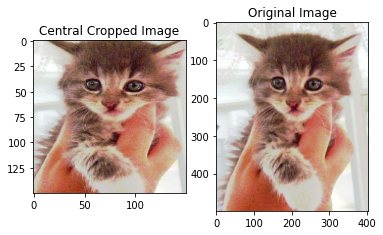

In [85]:
plt.figure()
plt.subplot(121)
plt.title("Central Cropped Image")
plt.imshow(central_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [86]:
checker.central_crop_fn_check(central_crop)

central_crop 함수를 잘 구현 하셨습니다! 이어서 진행하셔도 좋습니다.


#### `load_image_train`함수를 구현

* 학습용 이미지 load pipeline은 다음과 같습니다. 앞서 구현했던 3개의 함수들을 이용하여 구성해 봅니다.
* `load` -> `random_jitter` -> `normalize`
    1. image load
    2. random_jitter를 이용한 데이터 증식
    3. 이미지의 normalization
  
**load_image_train 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [87]:
def load_image_train(image_file, label):

    ## 코드 시작 ##
    input_image, label = load(image_file, label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)
    ## 코드 종료 ##

    return input_image, label

#### `load_image_val_and_test`함수를 구현

* 검증(validation) 및 테스트 이미지 load pipeline은 다음과 같습니다. 위에서 구현한 것과 마찬가지로 우리가 구현한 3개의 함수를 이용합니다.
* `load` -> `central_crop` -> `normalize`
    1. image load
    2. 변형을 최소화하는 `central_crop` 정도만 합니다.
    3. input 데이터 normalize

**load_image_val_and_test 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [88]:
def load_image_val_and_test(image_file, label):

    ## 코드 시작 ##
    input_image, label = load(image_file, label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)
    ## 코드 종료 ##

    return input_image, label

### Input pipeline

* 위에 정의한 augmentation 함수를 이용하여 input data pipeline 만듭니다.

In [89]:
def add_label(image_file, label):
    return image_file, label

In [90]:
# train folder에 있는 폴더 이름을 list로 나타냅니다.
# 즉 학습에 사용할 category의 이름을 list로 나타내는 것입니다.
folder_list = [f for f in os.listdir(os.path.join(PATH, 'train')) if not f.startswith('.')]

1. `tf.data.Dataset.list_files`을 이용하여 첫번째 폴더('cat')에 있는 `*.jpg`의 파일이름을 가져와서 `train_dataset`으로 만듭니다.
2. 해당 `dataset`에 `tf.data.Dataset.map`함수를 이용하여 label(0)을 추가합니다.
3. for문을 통해 `folder_list`에 있늘 폴더들을 두번째 부터 읽어옵니다.
4. `tf.data.Dataset.list_files`을 이용하여 두번째 폴더('dog')에 있는 `*.jpg`의 파일이름을 가져와서 `temp_dataset`으로 만듭니다.
5. 해당 `dataset`에 `tf.data.Dataset.map`함수를 이용하여 label(1)을 추가합니다.
6. `train_dataset`('cat' 데이터)와 `temp_dataset`('dog' 데이터)를 `tf.data.Dataset.concatenate`를 이용하여 합칩니다.
7. for문을 반복합니다. (각 카테고리의 데이터와 label이 차례로 `train_dataset`에 합쳐집니다.

In [91]:
train_dataset = tf.data.Dataset.list_files(                            # 1번
    os.path.join(PATH, 'train', folder_list[0], '*.jpg'))
train_dataset = train_dataset.map(lambda x: add_label(x, 0))          # 2번
for label, category_name in enumerate(folder_list[1:], 1):            # 3번
    temp_dataset = tf.data.Dataset.list_files(                         # 4번
        os.path.join(PATH, 'train', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))    # 5번
    train_dataset = train_dataset.concatenate(temp_dataset)            # 6번

In [92]:
N = BUFFER_SIZE = len(list(train_dataset)) # number of samples in train_dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [93]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
val_dataset = val_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    val_dataset = val_dataset.concatenate(temp_dataset)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [94]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'test')) if not f.startswith('.')]
test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))
test_dataset = test_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    test_dataset = test_dataset.concatenate(temp_dataset)

test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [95]:
checker.customized_dataset_check(train_dataset)

tf.data.Dataset을 이용하여 train_dataset을 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


### Augmented image 출력

데이터 증식이 적용된 훈련 이미지를 출력해봅니다.

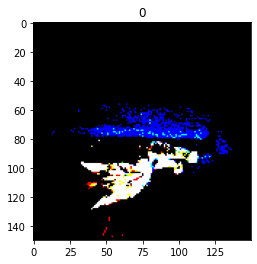

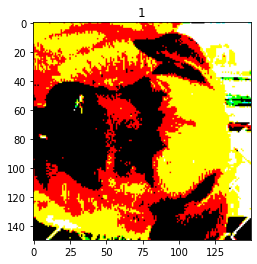

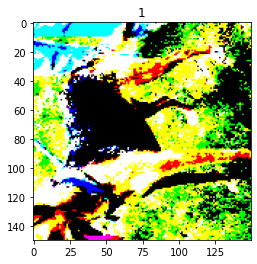

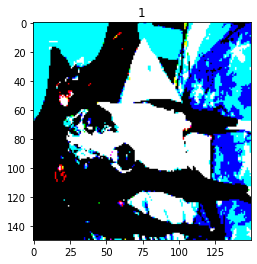

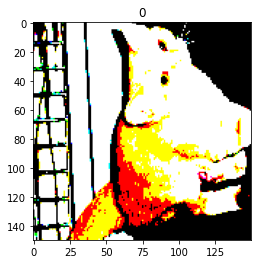

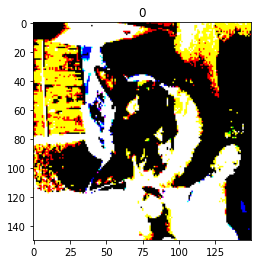

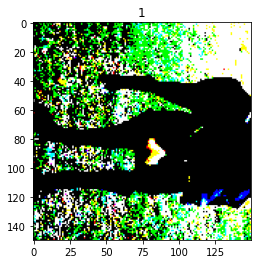

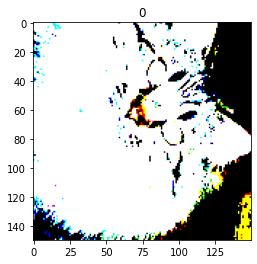

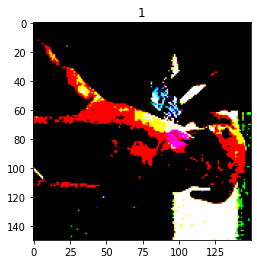

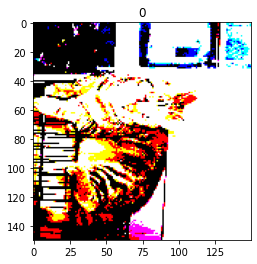

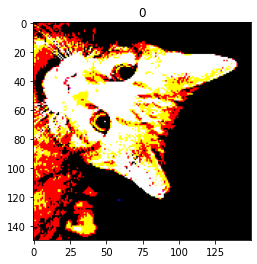

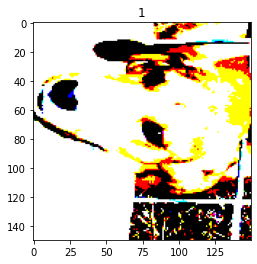

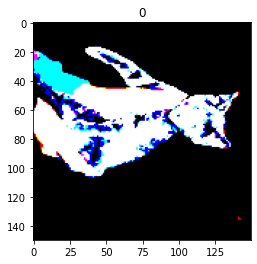

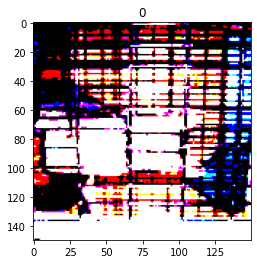

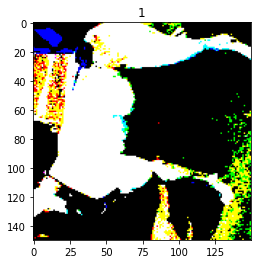

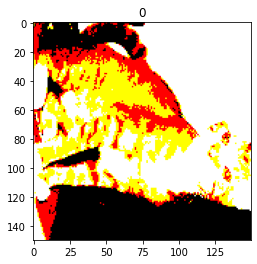

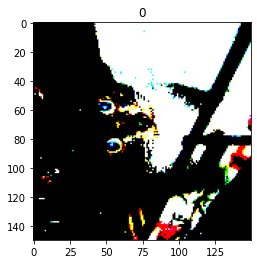

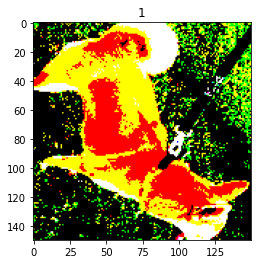

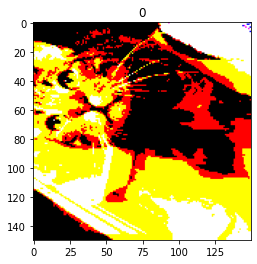

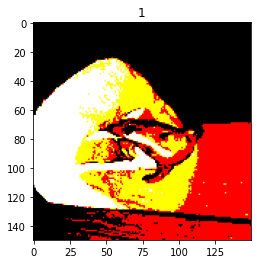

In [96]:
for images, labels in train_dataset.take(1):
    for j in range(20):
        plt.figure()
        plt.imshow(images[j])
        plt.title(labels[j].numpy())
        plt.show()

## 5. 네트워크 설계

이제 학습할 뉴럴네트워크를 설계합니다. 일반적으로 CNN 기반의 분류기는 먼저 일련의 convolutional layer를 통해 이미지에서 특징을 추출하고, 마지막에 추출된 특징을 dense layer를 통해 분류하는 구조를 많이 사용합니다.

### Conv layer(Conv - BatchNorm - ReLU - Pool) 만들기

### <font color='red'>[TODO] 코드 구현</font>

* 보통 Convolution 연산을 하고 나면 주로 Batch normalization - ReLU - MaxPooling 등의 연산을 차례대로 하게 됩니다. 따라서 자주 쓰이는 (Conv - BN - ReLU - MaxPooling) 연산을 `class` 형태로 만들어 두면 나중에 재사용하기 쉽습니다.
*  TensorFlow는 [`tf.keras.layers.Conv2d`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)를 이용해 convolutional layer를 만들 수 있습니다. 필요한 인자(arguments)는 필터의 개수(혹은 채널의 숫자)를 뜻하는 `num_filters` 와 필터(커널)의 크기인 `kernel_size` 입니다.
* 모든 convolutional layer 뒤에는 batch normalization([`tf.keras.layers.BatchNormalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization))을 적용하고 비선형 activation function으로 ReLU([`tf.keras.layers.ReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU))를 사용하겠습니다. 
* ReLU 적용 이후에는 2x2의 maxpooling([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D))을 적용하겠습니다. maxpooling 의 필터 크기는 `pool_size` 를 통해 조정합니다.
* 지금 만들 `class`에 `BatchNormalization`이 쓰이기 때문에 `class` 내부 `call`함수에 꼭 `training` 옵션을 주어야 합니다.
* [`class`](https://www.tensorflow.org/tutorials/customization/custom_layers) 사용은 링크를 참고해주세요.

**이제 Conv layer 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [102]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()

        ## 코드 시작 ##
        self.conv = tf.keras.layers.Conv2D(filters,kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D()
        ## 코드 종료 ##

    def call(self, inputs, training=True):

        ## 코드 시작 ##
        x = self.conv(inputs)    # self.conv forward
        x = self.bn(x)   # self.bn   forward
        x = self.relu(x)    # self.relu forward
        x = self.pool(x)    # self.pool forward
        ## 코드 종료 ##

        return x

방금 만든 Conv class가 올바르게 작동되는지 아래 코드를 통해 check 해보세요.

### <font color='red'>[TODO] 코드 구현: 네트워크 설계</font>

우리는 총 4개의 Convolutional layer (이하:`Conv`) 층을 통해 입력 이미지에서 특징을 추출할 것입니다. 다음을 읽고 코드를 완성해보세요.
- 각각의 `self.conv` 변수에 이전에 만든 `Conv` 층를 쌓을 것입니다. TensorFlow는 [`tf.keras.layers.Conv2d`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)를 이용해 convolutional layer를 사용할 수 있습니다.
- 모든 `Conv` 층의 필터 크기(kerner_size)는 3x3으로 하겠습니다.
- 먼저 쌓을 `Conv` 층의 입력 채널 수는 3입니다. 입력 이미지가 RGB 3채널이기 때문입니다. 출력 채널 수는 우리가 자유롭게 정해줄 수 있습니다. 이번에는 출력 채널 수를 32로 하겠습니다.
- 두 번째 `Conv` 층의 출력 채널 수는 64로 합니다.
- 세 번째 `Conv` 층의 출력 채널 수는 128로 합니다.
- 마지막 `Conv` 층의 출력 채널 수는 128로 합니다.

그 후, 분류기 역할을 하는 dense layer를 정의할 차례입니다. 다음을 읽고 코드를 완성해보세요.
- 우리는 총 2개의 dense layer를 쌓을 것입니다. 
- 첫 번째 dense layer(`self.dense1`)의 입력 뉴런 수는 convolution layer에서 가장 마지막에 추출된 특징의 크기에 따라 정해야 합니다. 여러분이 위의 설명대로 convolution layer를 쌓았다면 가장 마지막에 추출되는 특징의 크기는 5x5x128(height x width x channels)입니다. 첫 번째 dense layer의 출력 뉴런 수는 512로 해줍니다.
- 마지막 dense layer(`self.dense2`)의 출력 뉴런 수는 분류하고자 하는 class 개수와 같아야 합니다.
  - 여기서는 사실 두개의 class 밖에 없는 *binary classification* 문제라 마지막 출력 뉴런을 하나로하고 `sigmoid`를 취할 수도 있습니다.
  - 단 그럴경우에는 `CategoricalCrossentropy`가 아니라 `BinaryCrossentropy`를 쓰셔야 합니다.
  - 첫번째 dense layer 의 활성화 함수는 ReLU, 두번째 dense layer 의 활성화 함수는 Softmax 로 지정해주세요.

### <font color='blue'> [Tensorflow 1.x 버전과 2.x 버전의 차이점] </font>

- Tensorflow 1.x 버전과 2.x 버전의 가장 큰 차이점은 `eager`모드가 `default`로 변경되었다는 점입니다. 이전의 tensorflow에서는 계산 그래프를 지정해준 다음 session을 열어서 계산을 수행하는 방법을 이용했습니다. 2.x 버전으로 바뀌면서 eager 모드가 default가 되었고 `keras`의 `high-level api`가 표준 `api`로 정해졌습니다. 
- 앞으로 수행할 프로젝트에서는 `tf.keras`기반의 `sequential` 구조를 사용합니다. sequential 구조는 레고 쌓기 비유가 자주 사용됩니다. `layer`들을 하나씩 하나씩 `add` 하면서 전체 model을 완성하면 되기 때문입니다. 편하고 간결한 코드 때문에 단순한 모델에서 큰 장점이 있지만 복잡한 모델에서는 `class`형식으로 model을 구성합니다.

**이제 모델 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [105]:
model = tf.keras.Sequential()

##코드 시작##
model.add(Conv(32,3))
model.add(Conv(64,3))
model.add(Conv(128,3))
model.add(Conv(128,3))

model.add(tf.keras.layers.Flatten())  # flatten
model.add(tf.keras.layers.Dense(512,activation='relu'))  # relu
model.add(tf.keras.layers.Dense(2,activation='softmax'))  # softmax
##코드 종료##

In [106]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.6019194 , 0.39808053]], dtype=float32)>

In [107]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_6 (Conv)               (1, 74, 74, 32)           1024      
                                                                 
 conv_7 (Conv)               (1, 36, 36, 64)           18752     
                                                                 
 conv_8 (Conv)               (1, 17, 17, 128)          74368     
                                                                 
 conv_9 (Conv)               (1, 7, 7, 128)            148096    
                                                                 
 flatten_1 (Flatten)         (1, 6272)                 0         
                                                                 
 dense_2 (Dense)             (1, 512)                  3211776   
                                                                 
 dense_3 (Dense)             (1, 2)                   

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [108]:
checker.model_check(model)

네트워크를 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


## 모델 저장하기

`callback`을 이용하면 모델이 학습하면서 얻은 weight를 저장할 수 있습니다. 매 epoch마다 weights만 저장하는 코드를 작성해보세요.

저장한 모델 파일을 `model.load_weights()`를 통하여 불러올 수 있습니다. 모델의 저장 및 불러오기를 좀 더 자세히 알고 싶으면 [Save and restore](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko) 문서를 참고하세요.

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요. 

* 아래의 셀에서 채워야 할 인자는 checkpoint_path, save_weights_only, save_freq 입니다.
* verbose=1은 구현에 영향을 미치지는 않습니다. 정보 표현의 정도를 나타내는 것인데, 예를들면 verbose가 1이면 '이름'만을 말하고 2이면 '이름', '성별' 3이면 '이름', '성별', '나이'를 말하는 것입니다.

**이제 callback 코드를 작성해보세요!"<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [113]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

## 코드 시작 ##
# 체크포인트 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,save_freq='epoch',verbose=1)
## 코드 종료 ##

In [114]:
checker.callback_check(cp_callback)

callback을 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.


## 6. Loss function 및 Optimizer 정의

생성한 모델을 학습 시키기 위해서 손실함수를 정의해야 합니다. 뉴럴네트워크는 경사하강(gradient descent)방법을 이용하여 손실함수의 값을 줄이는 방향으로 파라미터를 갱신(update) 하게 됩니다. 또한 효과적인 경사하강 방법을 적용하기 위해 옵티마이져를 함께 사용할 겁니다.


### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요.
- `compile` 앞서 정의한 model에서 training을 위해 loss와 optimizer를 지정해주세요. [tf.Keras.Model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
- `loss` [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)와 [Cross Entropy Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)의 차이점을 읽고 데이터에 맞는 loss를 정의하세요.
- `optimizer` 변수에 [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)를  **<3. 하이퍼파라미터 세팅>** 에서 정의한 `learning_rate` 에 맞게 학습률을 지정해보세요!
- `metrics` accuracy로 정의하세요.

### <font color='blue'> [Tensorflow 1.x 버전과 2.x 버전의 차이점] </font>

- `loss`, `optimizer`, `metric` 등을 `model.compile`을 통해 한꺼번에 쉽고 가독성 있게 설정할 수 있게 되었습니다. 

**이제 손실함수와 옵티마이저 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [117]:
## 코드 시작 ##
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])
## 코드 종료 ##

In [118]:
checker.compile_check(model)

compile을 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.


## 7. Training

네트워크의 규모가 큰 편이 아니지만, GPU 가 없다면, CPU를 통해 학습되기 때문에 시간이 조금 필요합니다. 컴퓨터 성능에 따라 20~30분의 시간이 소요될 수 있습니다.

만약 어느정도 기다렸음에도 학습 accuracy가 증가하지 않는다면 구현한 코드에 문제가 있을 수 있습니다. 

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요.
- [`tf.keras.Model의 Method인 fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)을 이용하여 학습을 시작하세요.
- `tf.data.Dataset`으로 만든 객체인 `train_dataset`을 input으로 넣어주세요.
- input으로 tf.data를 이용하는 경우 `steps_per_epoch` 을 지정해주어야 합니다. train_data의 길이를 batch_size 크기로 나눈 값을 지정해주세요.
- `validation_data`와 `validation_steps` 도 같이 지정해주세요.
- `epochs`를 미리 변수에 담아둔 값으로 지정해주세요.
- `callbacks`를 이용하여 모델 weight를 저장해주세요.

**이제 각 스텝에 따라 훈련 단계 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [119]:
train_len = len(glob(os.path.join(PATH, 'train', folder_list[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))) * 2

In [122]:
## 코드 시작 ##
model.fit(train_dataset, steps_per_epoch = train_len//batch_size,
          validation_data=val_dataset , 
          validation_steps= val_epoch,
         epochs= max_epochs,
         callbacks= [cp_callback])
## 코드 종료 ##

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.8933 - accuracy: 0.5545
Epoch 1: saving model to ./train/exp_cnn/cp-0001.ckpt
100/100 [==============================] - 359s 4s/step - loss: 0.8933 - accuracy: 0.5545 - val_loss: 0.1478 - val_accuracy: 1.0000
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.6205
Epoch 2: saving model to ./train/exp_cnn/cp-0002.ckpt
100/100 [==============================] - 15s 146ms/step - loss: 0.6821 - accuracy: 0.6205 - val_loss: 0.3191 - val_accuracy: 1.0000
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.6336 - accuracy: 0.6551
Epoch 3: saving model to ./train/exp_cnn/cp-0003.ckpt
100/100 [==============================] - 17s 165ms/step - loss: 0.6350 - accuracy: 0.6545 - val_loss: 0.5666 - val_accuracy: 0.7500
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6576
Epoch 4: saving model to ./train/exp_cnn/cp-0004.ckpt


`accuracy`가 **80%** 내외로 나오면 학습이 잘 된 것입니다.

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 별다른 문제가 없다면 이어서 진행하면 됩니다.

In [123]:
checker.accuracy_check(model)

fit을 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.


## 8. 저장된 모델 불러오기 및 Evaluation

학습한 모델의 성능을 테스트합니다. 저장한 모델 파일을 `model.load_weights()`를 통하여 불러올 수 있습니다. 모델의 저장 및 불러오기를 좀 더 자세히 알고 싶으면 [Save and restore](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko) 문서를 참고하세요.

### <font color='red'>[TODO] 코드 구현</font>

`5.네트워크 설계`와 `6. Loss function 및 Optimizer 정의`를 문제 없이 통과하신 분은 그대로 넣으시면 됩니다.

In [124]:
model = tf.keras.Sequential()

##코드 시작##
model.add(Conv(32,3))
model.add(Conv(64,3))
model.add(Conv(128,3))
model.add(Conv(128,3))

model.add(tf.keras.layers.Flatten())  # flatten
model.add(tf.keras.layers.Dense(512,activation='relu'))  # relu
model.add(tf.keras.layers.Dense(2,activation='softmax'))  # softmax

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])
##코드 종료##

# inputs을 넣어 모델 생성
for images, labels in train_dataset.take(1):
    outputs = model(images, training=False)

In [125]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./train/exp_cnn/cp-0020.ckpt'

In [126]:
model.load_weights(latest)

마지막으로 모델의 성능을 테스트합니다. `10epoch`이상을 학습했을 때 **75%** 내외의 성능이 나온다면 학습 및 모델 불러오기가 성공적으로 진행된 것입니다. 

In [127]:
model.evaluate(test_dataset, steps=test_len/batch_size)

100/100 [==============================] - 717s 9ms/step - loss: 0.7225 - accuracy: 0.6030


[0.7225469946861267, 0.6029999852180481]

In [128]:
checker.test_check(model)

모델 성능이 기준치를 넘었습니다! 이어서 진행하셔도 좋습니다.


학습된 모델의 예측 결과를 시각화하면 다음과 같습니다. label이 <font color='blue'>파란색</font>으로 표시되면 모델이 정확한 예측을 한 것이고 <font color='red'>빨간색</font>으로 표시되면 틀린 예측을 한 것입니다. 틀린 경우에는 모델의 예측과 함께 실제 정답을 표기해두었습니다. (ex. 오답/정답)

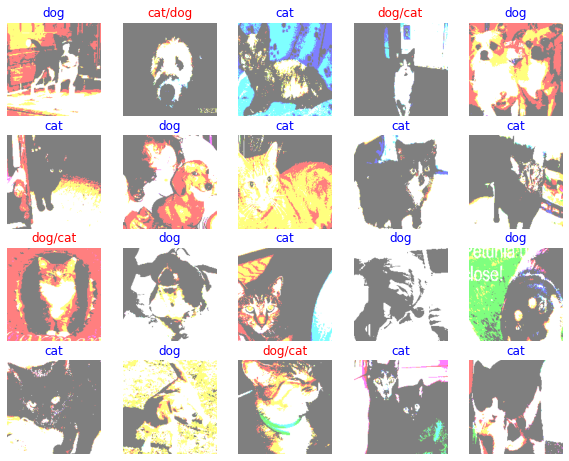

In [129]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

## 9. Transfer Learning

실습을 끝내기전에, 우리는 전이 학습(transfer learning)을 구현해 보고 성능을 확인해 볼 것입니다. 
전이학습이란 비슷한 목적으로 미리 학습된 모델의 파라미터로 나의 모델의 파라미터를 초기화한 후 학습을 이어서 진행하는 것을 말합니다. 그렇다면 이러한 전이학습은 어떤 장점이 있기에 사용하는 것일까요?

여러분이 현실에서 딥러닝을 활용할 때 흔히 마주칠 수 있는 현실적인 제약들이 있습니다. 데이터 부족, 컴퓨팅 리소스 부족, 시간의 부족이 대표적인 현실적인 제약들에 속합니다. 우리가 풀고자 하는 문제와 완전히 똑같지는 않지만 어느정도 연관성이 있는 문제를, 아주 많은 양의 데이터로, 미리 학습한 모델이 있다면 그 모델은 정말 아무것도 모르는 백지 상태의 모델보다 우리가 풀고 싶은 문제에 대해 훨씬 더 빨리 배우고 잘 배울 수 있습니다. 

구현은 전혀 어렵지 않습니다. 먼저 미리 학습된 모델을 불러와야 합니다. 
여기서 불러올 모델은 VGG16으로, 대규모 ImageNet 데이터로 이미지 분류를 학습한 모델입니다.

`tf.keras.application`을 이용하여 VGG16을 불러옵니다. 학습된 파라미터를 다운받기 위해 몇 분의 시간이 소요될 수 있습니다.

In [130]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 [==============================] - 3s 0us/step


우리가 불러온 ImageNet에 학습된 VGG16은 1000개의 class를 구분하는 네트워크입니다. 그리고 크게 다음과 같은 레이어로 이루어져 있습니다.

>```
conv_block1
conv_block2
conv_block3
conv_block4
conv_block5
dense1 (4096)
dense2 (4096)
dense3 (1000)
>```

`tf.keras.applications.VGG16()` 이 함수로 네트워크를 불러오면 모든 레이어를 다 다운 받아 저장합니다. 여기서 `include_top`이라는 중요한 인자(argument)가 있습니다. `include_top=False`라면 VGG16에서 `dense1` ~ `dense3`레이어를 불러오지 않고 오직 `conv`레이어만 불러옵니다. 보통 레이어가 많아서 깊은 네트워크일 경우 input쪽에 가까운 layer에서는 일반화된(general) 성질의 피쳐(feature)가 뽑히고 아랫쪽으로 갈 수록 dataset의 영향을 더 받는 피쳐들이 학습이 됩니다. 따라서 전이학습을 통하여 자신의 데이터를 학습시키고 싶을 때는 일반화된 성질을 뽑아내는 `conv`레이어만 살리고 `dense`레이어는 제거 후, 우리 데이터 셋에 맞게 `dense` 레이어를 재조직합니다. 이렇게 `conv`레이어만 살리는 모델을 만들때 사용하는 argument가 `include_top=False`입니다.

이제 방금 불러온 `conv_base`에 새로 `dense layer`를 붙여 우리의 모델을 만들 것 입니다. 그리고 학습은 방금 추가한 `dense layer`들과 마지막 `conv block` (정식 이름은 `block5_conv1` ~ `block5_conv3`)에 대해서만 진행합니다.

물론 상황에 따라서는 우리가 이번에 하는 것처럼 마지막 dense layer만 학습을 진행하는 것이 아니라 전체 네트워크에 대해서 학습을 이어서 진행하는 경우도 있습니다. 이를 파라미터 fine tuning(미세 조정)이라고 합니다. ImageNet에는 다양한 동물 class도 포함이 되어있습니다. 즉, 우리가 불러온 ResNet은 강아지와 고양이 같은 동물에 대한 특징을 이미 어느정도 잘 추출하는 네트워크인 것입니다. 따라서 fine tuning이 굳이 필요하지 않습니다. 게다가, 이번 실습과 같이 적은 양의 데이터를 통해 모델을 학습시키는 상황에서 fine tuning을 진행하는 것은 overfitting의 가능성이 커지는 것이기 때문에 오히려 성능을 낮추는 결과를 가져올 수 있습니다.

### <font color='red'>[TODO] 코드 구현: dense layer</font>

다음을 읽고 코드를 완성해보세요.

- hidden_size = 256 짜리 dense layer와 hidden_size = num_class를 갖는 마지막 dense layer를 구현합니다.
    - 첫번째 layer는 `ReLU`, 두번째는 `softmax`를 activation function으로 갖습니다.
  
**전이학습을 위해 dense layer 코드를 추가해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [133]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

# 코드 시작
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(2,activation='softmax'))
# 코드 종료

In [134]:
# training variable 확인
for var in model.trainable_variables:
    print(var.name)

block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_6/kernel:0
dense_6/bias:0
dense_7/kernel:0
dense_7/bias:0


VGG16은 다음과 같이 이루어져 있습니다.

>```
conv_block1
conv_block2
conv_block3
conv_block4
conv_block5
new_dense1
new_dense2
>```

우리는 `conv_block5`부터 새로붙인 `new_dense`레이어를 이용하여 fine tuning을 할 것 입니다. 그렇게 하기 위해 training 할 layer와 아닌 layer를 밑에 코드로 구분짓습니다.

In [135]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [136]:
# training variable 확인
for var in model.trainable_variables:
    print(var.name)

block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_6/kernel:0
dense_6/bias:0
dense_7/kernel:0
dense_7/bias:0


trainig flag(True, False)를 조절하여 `conv_block5` 이후만 training하게 만들었습니다.

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [137]:
checker.final_dense_check(model)

dense layer 잘 수정하셨습니다! 이어서 진행하셔도 좋습니다.


### <font color='red'>[TODO] 코드 구현: 재학습을 위한 손실함수 및 옵티마이저 정의</font>

불러온 모델에 대한 학습을 진행하기 위해 손실함수와 옵티마이저를 다시 정의합니다. 

**전이학습을 위해 손실함수와 옵티마이저를 새로 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.** 

In [140]:
## 코드 시작 ##
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])
## 코드 종료 ##

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요. 

이번엔 `validation loss`가 **가장 작은 값만** callback에 저장해보세요.
* 아래의 셀에서 채워야 할 인자는 checkpoint_path, save_best_only, save_weights_only 입니다

**이제 callback 코드를 작성해보세요!"<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [141]:
checkpoint_path = "./train/exp_pre_trained/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 만들기
## 코드 시작 ##
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,save_freq='epoch',verbose=1)
## 코드 종료 ##

불러온 모델에 대해 학습을 진행합니다. 우리가 직접 만든 네트워크는 20epoch 정도 돌렸습니다. 하지만 transfer learning은 이미 학습되어 있는 파라미터를 초깃값으로 써서 학습을 시작하기 때문에 짧은 epoch만 돌려도 좋은 성능을 얻을 수 있습니다. 우리는 5epoch만 돌려보겠습니다.

In [142]:
model.fit(train_dataset, steps_per_epoch = train_len//batch_size,
          validation_data=val_dataset, 
          validation_steps= val_epoch,
          epochs= 5,
          callbacks= [cp_callback])

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6515
Epoch 1: saving model to ./train/exp_pre_trained/cp.ckpt
100/100 [==============================] - 17s 145ms/step - loss: 0.6341 - accuracy: 0.6515 - val_loss: 0.6817 - val_accuracy: 0.6500
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.7665
Epoch 2: saving model to ./train/exp_pre_trained/cp.ckpt
100/100 [==============================] - 13s 127ms/step - loss: 0.4740 - accuracy: 0.7665 - val_loss: 0.7038 - val_accuracy: 0.6000
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8135
Epoch 3: saving model to ./train/exp_pre_trained/cp.ckpt
100/100 [==============================] - 12s 120ms/step - loss: 0.4128 - accuracy: 0.8135 - val_loss: 1.0656 - val_accuracy: 0.4500
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8650
Epoch 4: saving model to ./train/exp_pre_traine

학습이 끝난 후 모델을 새로 만들고 최고 성능을 내는 모델을 load 하여 test를 수행합니다.

### <font color='red'>[TODO] 코드 구현: dense layer</font>

위에서 구현한 모델과 손실함수, 옵티마이저를 그대로 사용하시면 됩니다.

- hidden_size = 256 짜리 dense layer와 hidden_size = num_class를 갖는 마지막 dense layer를 구현합니다.
    - 첫번째 layer는 `ReLU`, 두번째는 `softmax`를 activation function으로 갖습니다.

### <font color='blue'> [잠깐! 좀 더 알아볼까요?] </font>

"왜 자꾸 반복해서 모델과 Optimizer와 Loss를 반복해서 적어야 하는거야?" 라고 궁금해 하셨을 수도 있습니다. 앞에서 `callback`으로 저장한 파일에는 모델의 Weight만 담겨 있습니다. 그렇기 때문에 불러올때마다 필요한 부분을 계속해서 적어야 하는 것입니다. 그렇다면 모델의 구조와 Weight, Opimizer, Loss까지 전부 저장하려면 어떻게 하면 될까요? 바로 `model.save('파일명', save_format='tf')`을 이용하면 됩니다. 그리고 저장한 모델을 불러오려면 `tf.keras.models.load_model('파일명')`을 사용하시면 됩니다. 좀 더 자세한 내용은 [Save and restore](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko) 참고해주세요.

In [143]:
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

# 코드 시작
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(2,activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])
# 코드 종료

In [144]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16,812,610
Trainable params: 9,177,346
Non-trainable params: 7,635,264
_________________________________________________________________


In [145]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

테스트를 수행합니다. 정확도가 95% 내외가 나온다면 성공적으로 진행된 것입니다. 마지막 레이어 몇개만 학습시켰음에도 우리의 SimpleCNN보다 성능이 훨씬 좋은 것을 볼 수 있습니다.

In [146]:
model.evaluate(test_dataset, steps= test_len/batch_size)

100/100 [==============================] - 12s 65ms/step - loss: 0.5233 - accuracy: 0.7695


[0.5233440399169922, 0.7695000171661377]

## 10. Summary

이로써 또 하나의 프로젝트를 완료했습니다. 고생하셨습니다! 

우리는 이번 실습을 통해 다음과 같은 내용을 학습했습니다.
- Dataset class를 우리가 가진 데이터셋에 맞게 customize 하여 정의할 수 있다.
- CNN을 설계하고 이미지 분류기를 학습시킬 수 있다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 데이터, 리소스, 시간이 부족한 상황에서 전이학습을 사용하여 이를 극복할 수 있다.

---

# Self-Review

학습 환경에 맞춰 알맞는 제출방법을 실행하세요!

### 로컬 환경 실행자

1. 모든 실습 완료 후, Jupyter Notebook 을 `Ctrl+S` 혹은 `File > Save and checkpoint`로 저장합니다.
2. 제일 하단의 코드를 실행합니다. 주의할 점은 Jupyter Notebook 의 파일이름을 수정하시면 안됩니다! 만약에 노트북 이름을 수정했다면 "tensorflow-cnn-project" 로 바꿔주시길 바랍니다. 모든 평가 기준을 통과하면, 함수 실행 후 프로젝트 "submit" 디렉토리와 압축된 "submit.zip"이 생깁니다. "cnn_submission.tsv" 파일을 열고 모두 Pass 했는지 확인해보세요!
    * "cnn_submission.tsv" : 평가 기준표에 근거해 각 세부항목의 통과여부(Pass/Fail) 파일
    * "cnn_submission.html" : 여러분이 작성한 Jupyter Notebook 을 html 형식으로 전환한 파일
3. 코드 실행결과 안내에 따라서 `submit.zip` 파일을 확인하시고 제출해주시길 바랍니다.

### Colab 환경 실행자

1. 모든 실습 완료 후, Jupyter Notebook 을 `Ctrl+S` 로 저장합니다.
2. 제일 하단의 코드를 실행합니다. 코드 실행결과 안내에 따라서 재작성하거나 다음스텝으로 넘어갑니다. 모든 평가 기준을 통과하면, 함수 실행 후 프로젝트 "submit" 디렉토리와 압축된 "cnn_submission.tsv"만 생깁니다. "cnn_submission.tsv" 파일을 열고 모두 Pass 했는지 확인해보세요!
    * "cnn_submission.tsv" : 평가 기준표에 근거해 각 세부항목의 통과여부(Pass/Fail) 파일
3. 프로젝트를 저장한 드라이브의 `submit` 폴더에서 `cnn_submission.tsv` 파일을 다운 받습니다.
4. Colab Notebook 에서 `파일 > .ipynb 다운로드`를 통해서 노트북을 다운로드 받습니다.
5. 로컬에서 Jupyter Notebook 프로그램을 실행시킵니다. 
6. 4번 스텝에서 다운받은 노트북을 열고 `File > Download as > HTML(.html)` 로 재 다운로드 합니다.
7. 3번 스텝에서 받은 파일과 6번 스텝에서 받은 파일을 하나의 폴더에 넣고, `submit.zip` 이라는 이름으로 압축하고 제출해주시길 바랍니다.

In [147]:
import check_util.submit as submit
submit.process_submit()

[ Self-Check ] 시스템: Linux
[ Self-Check ] Submit 파일 생성완료! 위치: 'submit'
[ Self-Check ] submit.zip 생성 완료!
[ Self-Check ] 모든 평가기준을 통과했습니다. 압축파일을 제출해주세요!
